![img](https://miro.medium.com/max/802/1*u7swL7CrX0UW_lIScu1eDQ.png)
# 1B. Introduction to Machine Learning with H2O-3-regression

In this tutorial we will use the subset of the Freddie Mac Single-Family dataset to try to predict the interest rate for a loan using H2O's XGBoost and Deep Learning models. We will explore how to use these models for a regression problem, and we will also demonstrate how to use H2O's grid search to tune the hyper-parameters of both models.

### Installations

In [1]:
# installing java
! apt-get install default-jre
! java -version
# install h2o
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.8MB 40kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=36ea815176c7d1bd3df7a25006d3668fbaecfd9fea3f0c570d09e9a3bc82b5d0
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


### Task 1: Init

In [2]:
#Import H2O and other libaries that will be used in this tutorial 
import h2o
from h2o.estimators import *
from h2o.grid import *

We now have to initialize our instance. If you are on Aquarium, it will connect to a local instance; if you are on your own machine, it will launch an instance connected to your machine.

In [3]:
import os

startup  = '/home/h2o/bin/aquarium_startup'
shutdown = '/home/h2o/bin/aquarium_stop'

if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
else:
    local_url = 'http://localhost:54321'
    aquarium = False

In [4]:
h2o.init(url = local_url)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeclqarp1
  JVM stdout: /tmp/tmpeclqarp1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpeclqarp1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,10 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_tuhx8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
#Import the dataset from an AWS instance 
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Task 2: Regression Concepts

Regression ► Regression tries to predict a continuous number (as opposed to classification, which only categorizes). With a regressor model, you try to predict the exact number from your response column. In our case, we will try to predict the interest rate (a continuous value). You will see later on that some samples might have a 7.5% interest rate, and our regression model will try to predict that number.

Some metrics:

*   MSE ► measures the average of the squares of the errors or deviations. MSE takes the distances from the points to the regression line (these distances are the "errors") and squaring them to remove any negative signs. MSE incorporates both the variance and the bias of the predictor. MSE also gives more weight to larger differences.

*   RMSE ► evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not, but is sensitive to outliers.

*   MAE ► is an average of the absolute errors. The MAE units are the same as the predicted target as well as the RMSW, which is also useful for understanding whether the size of the error is of concern or not.

For a detailed description of the other metrics, please check: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html#evaluation-model-metrics

Based-Tree Algorithms:

*   Decision Trees ► uses a tree-like model of decisions to make a prediction. Decision trees subdivide the dataset and move event outcomes left and right to build the tree model and fit all the data. The series of questions are generated automatically to optimize the separation of the data points depending on what you are trying to find whether you are doing a regression or classification tree. (non-linear / correlated features doe not eaffect their performance / robust to missing values)

*   Tree Ensembles ► combine several decision trees in order to solve the same problem and make better predictions. One example of tree ensembles is Random Forest, which uses bagging or bootstrap aggregation, meaning we fit many different trees on different samples of the data.

*   XGBoost ► another decision-tree-based ensemble that uses boosting to yield accurate models, XGBoost provides parallel tree boosting (also known as GBDT, GBM) that solves many data science problems in a fast and accurate manner. For many problems, XGBoost is one of the best GBM frameworks today.

*   Deep Learning ► is a subset of machine learning that uses neural networks to solve complex problems that other machine learning algorithms have difficulties with, such as image classification, speech recognition, etc. Deep Learning models have an advantage over standard machine learning because they are very effective at learning non-linear derived features from the input features. Neural networks are algorithms based on how the human brain works because they are composed of nodes or commonly known as "neurons," and thus the name of neural networks.
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#deep-learning-neural-networks


### Task 3: Start Experiment

In [6]:
# First 10 dtaset rows
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [7]:
# Some descriptive analytics values
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


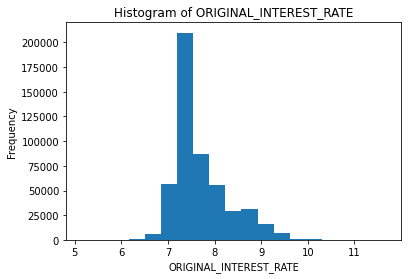

In [8]:
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [9]:
# Spliting data into Training, validation and test.
train, valid, test = loan_level.split_frame([0.70, 0.15], seed = 42)
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:350268 valid:74971 test:74898


In [10]:
# Choose your y variable response, and the x variable or predictor
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))

### Task 4: Build an XGBoost Model

In [11]:
# Build and train the model
xgb = H2OXGBoostEstimator(seed = 42, 
                          model_id = 'XGBoost', 
                          nfolds = 0, 
                          keep_cross_validation_predictions = False)

%time xgb.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Model Build progress: |██████████████████████████████████████████| 100%
CPU times: user 759 ms, sys: 67.5 ms, total: 827 ms
Wall time: 34 s


In [12]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-04-30 04:31:56,0.342 sec,0.0,6.708863,6.683679,45.008844,6.704750,6.679805,44.953673
1,,2021-04-30 04:31:59,3.158 sec,1.0,4.710473,4.678698,22.188559,4.707354,4.675791,22.159185
2,,2021-04-30 04:31:59,4.098 sec,2.0,3.316827,3.275220,11.001343,3.313931,3.272599,10.982141
3,,2021-04-30 04:32:00,4.827 sec,3.0,2.348813,2.292739,5.516923,2.346267,2.290480,5.504970
4,,2021-04-30 04:32:01,5.596 sec,4.0,1.681035,1.605171,2.825880,1.678602,1.603109,2.817706
5,,2021-04-30 04:32:05,10.097 sec,12.0,0.467832,0.329612,0.218867,0.467097,0.330447,0.218179
6,,2021-04-30 04:32:10,14.224 sec,19.0,0.444173,0.325207,0.197290,0.444243,0.326696,0.197352
7,,2021-04-30 04:32:14,18.698 sec,27.0,0.435665,0.318813,0.189804,0.436478,0.320970,0.190513
8,,2021-04-30 04:32:19,23.878 sec,36.0,0.428852,0.313160,0.183914,0.430202,0.315791,0.185074
9,,2021-04-30 04:32:26,30.258 sec,47.0,0.422619,0.308246,0.178607,0.425466,0.311725,0.181021



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",25657.996094,1.000000,0.239125
1,OCCUPANCY_STATUS.I,7086.139160,0.276177,0.066041
2,ORIGINAL_UPB,6440.511230,0.251014,0.060024
3,ORIGINAL_LOAN_TO_VALUE,5813.790527,0.226588,0.054183
4,LOAN_PURPOSE.P,4025.863281,0.156905,0.037520
5,CREDIT_SCORE,3827.817139,0.149186,0.035674
6,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",3514.124512,0.136960,0.032751
7,SELLER_NAME.COUNTRYWIDE,3313.306641,0.129133,0.030879
8,SELLER_NAME.NATLCITYMTGECO,3025.856445,0.117930,0.028200
9,SELLER_NAME.CROSSLANDMTGECORP,2976.497314,0.116007,0.027740



See the whole table with table.as_data_frame()


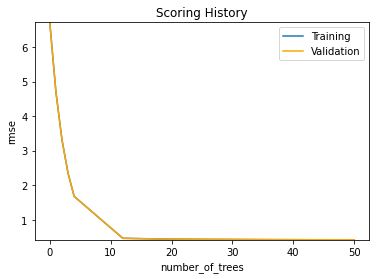

In [13]:
# plot the scoring history.
xgb.plot()

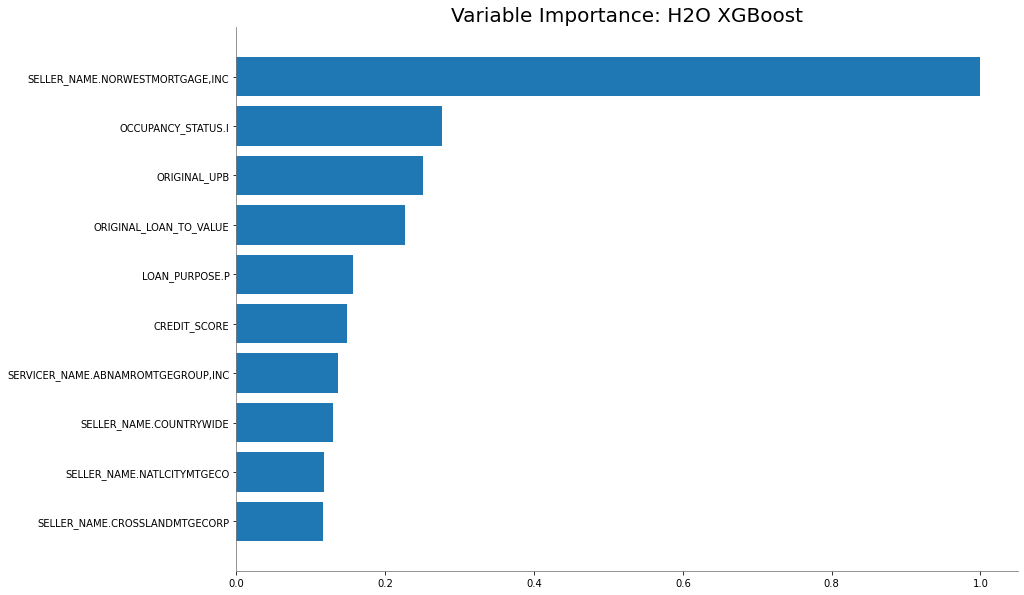

In [14]:
# variable importance plot.
xgb.varimp_plot()

In [16]:
# Some predictions on the validation set.
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [17]:
# Save model performance.
default_xgb_per = xgb.model_performance(valid)